In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False, dtype='uint8')

/home/kimegitee/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [62]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataset = {
    'train': {}, 
    'test': {}
}

for group, data in [("train", mnist.train),("test", mnist.test)]:
    images, labels = preprocess(data.images, data.labels)
    dataset[group]['images'] = images
    dataset[group]['labels'] = labels

In [16]:
for group in ['train', 'test']:
    images = dataset[group]['images']
    labels = dataset[group]['labels']
    for i in range(len(images)):
        writedata(i, images[i], labels[i], group)

In [9]:
def preprocess2(path, images, labels, size, num_samples=1, digit_range=(1, 2)):
    imgdir = path + '/images/'
    lbldir = path + '/labels/'
    for path in [imgdir, lbldir]:
        if not os.path.exists(path):
            os.makedirs(path)
    for sample_idx in range(1, num_samples+1):
        img_name = '{:05d}.png'.format(sample_idx)
        xml_name = '{:05d}.xml'.format(sample_idx)
        img_path = imgdir + img_name
        canvas = np.zeros(size, 'uint8')
        xml = ''
        num_digits = np.random.randint(*digit_range)
        for i in np.random.randint(0, len(data.images), size=num_digits):
            img = pickimg(data.images, i)
            lbl = data.labels[i]
            img = applyscaling(img)
            img = croptobbox(img)
            tl_i = np.random.randint(0, canvas.shape[0] - img.shape[0])
            tl_j = np.random.randint(0, canvas.shape[1] - img.shape[1])
            br_i = tl_i + img.shape[0]
            br_j = tl_j + img.shape[1]
            placeincanvas(canvas, img, tl_i, tl_j)
            xml += obj_xml.format(lbl, tl_j, tl_i, br_j, br_i)
        xml = ann_xml.format(img_name, *size, xml)
        cv2.imwrite(imgdir + img_name, canvas)
        with open(lbldir + xml_name, 'x') as f:
            f.write(xml)
        
for group, data in [("train", mnist.train),("test", mnist.test)]:
    preprocess2('./data/256-simple/' + group, data.images, data.labels, (256, 256), num_samples=data.images.shape[0])
    
        

In [3]:
obj_xml = '''
    <object>
        <name>{}</name>
        <bndbox>
            <xmin>{}</xmin>
            <ymin>{}</ymin>
            <xmax>{}</xmax>
            <ymax>{}</ymax>
        </bndbox>
    </object>\
'''

ann_xml = '''\
<annotation>
    <filename>{}</filename>
    <size>
        <width>{}</width>
        <height>{}</height>
        <depth>3</depth>
    </size>{}
</annotation>\
'''

def writedata(idx, image, label, group):
    imgdir = 'data/' + group + '/images/'
    lbldir = 'data/' + group + '/labels/'
    if not os.path.exists(imgdir):
        os.makedirs(imgdir)
    if not os.path.exists(lbldir):
        os.makedirs(lbldir)
    imgname = '{:05d}.png'.format(idx)
    xmlname = '{:05d}.xml'.format(idx)
    cv2.imwrite(imgdir + imgname, image)
    xml = ''
    for i in [0, 1]:
        true_label = label[i+2]
        xmin, ymin = label[i][0]
        xmax, ymax = label[i][1]
        xml += obj_xml.format(
            true_label, xmin, ymin, xmax, ymax)
    xml = ann_xml.format(imgname, xml)
    with open(lbldir + xmlname, 'x') as file:
        file.write(xml)
    
    
def preprocess(data, targets):
    images = []
    labels = []
    for i in range(data.shape[0]):
        idx1 = i
        idx2 = np.random.choice(data.shape[0])
        img1 = pickimg(data, idx1)
        img2 = pickimg(data, idx2)
        img, coords = combine(img1, img2)
        images.append(img)
        coords.extend([targets[idx1], targets[idx2]])
        labels.append(coords)
    return images, labels

def plotbbox(img, xmin, ymin, xmax, ymax):
    img = np.copy(img)
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 1)
    plt.imshow(img)
    plt.show()
    
def combine(img1, img2, w=40):
    '''Overlay 2 images
    Returns:
        New image and bounding box locations
    '''
    img1 = croptobbox(img1)
    img2 = croptobbox(img2)
    img3 = np.zeros([w, w], 'uint8')
    i1, i2 = np.random.randint(15, 25, size=2)
    j1, j2 = np.random.randint(12, 16, size=2)
    mask = img2 > 0
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    i1 = i1 - h1//2
    i2 = i2 - h2//2
    j1 = j1 - w1//2
    j2 = j2 - w2//2 + 12
    img3[i1:i1+h1, j1:j1+w1] = img1
    img3[i2:i2+h2, j2:j2+w2][mask] = img2[mask]
    tl1 = j1, i1 # topleft row and column indices
    br1 = j1 + w1, i1 + h1 # bottom right
    tl2 = j2, i2
    br2 = j2 + w2, i2 + h2
    return img3, [[tl1, br1], [tl2, br2]]

def pickimg(images, index):
    '''Pick one from images'''
    return np.copy(images[index].reshape([28, 28]))

def findbbox(img):
    a = np.where(img != 0)
    bbox = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
    return bbox

def croptobbox(img):
    '''Crop image to bounding box size'''
    a = np.where(img != 0)
    xmin, xmax, ymin, ymax = np.min(a[1]), np.max(a[1]), np.min(a[0]), np.max(a[0])
    return np.copy(img[ymin:ymax, xmin:xmax])

def placeincanvas(canvas, img, i, j):
    # Mutates canvas
    mask = img > 0
    canvas[i:i+img.shape[0], j:j+img.shape[1]][mask] = img[mask]
    
def applyscaling(img, size=None):
    fx = 2**np.random.sample()
    fy = 2**np.random.sample()
    if size is not None:
        x, y = size
        return cv2.resize(np.copy(img), size, interpolation=cv2.INTER_CUBIC)
    return cv2.resize(np.copy(img), None, fx=fx, fy=fy, interpolation=cv2.INTER_CUBIC)

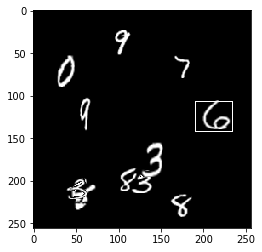

In [635]:
img = cv2.imread('data/256x256/train/images/00001.png')
plotbbox(img, 190, 107, 234, 142)

In [77]:
current_dir = os.getcwd()
print(current_dir)
os.chdir('sample')
files = glob.glob('*.png')
for file in files:
    name = file[:-4]
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255 - img
    images = []
    images.append(img[:,:256])
    images.append(img[:,256:512])
    images.append(img[:,512:])
    for i in range(len(images)):
#         mask = images[i] > 80
#         images[i][mask] = 255
        cv2.imwrite('out/' + name + '_' + str(i) + '.png', images[i])
os.chdir(current_dir)

/home/kimegitee/ner-lstm
